### Parsing the source text and extracting the required information

In [2]:
# The source text provided by the user
source_text = """
Epoch 1/100
----------
train epoch 1:loss 0.1727 with data size 78468
val epoch 1:loss 0.1614 with data size 11219
saving
Epoch 2/100
----------
train epoch 2:loss 0.1593 with data size 78468
val epoch 2:loss 0.1545 with data size 11219
saving
Epoch 3/100
----------
train epoch 3:loss 0.1536 with data size 78468
val epoch 3:loss 0.1515 with data size 11219
saving
Epoch 4/100
----------
train epoch 4:loss 0.1500 with data size 78468
val epoch 4:loss 0.1509 with data size 11219
saving
Epoch 5/100
----------
train epoch 5:loss 0.1473 with data size 78468
val epoch 5:loss 0.1490 with data size 11219
saving
Epoch 6/100
----------
train epoch 6:loss 0.1449 with data size 78468
val epoch 6:loss 0.1480 with data size 11219
saving
Epoch 7/100
----------
train epoch 7:loss 0.1428 with data size 78468
val epoch 7:loss 0.1493 with data size 11219
decay loss from 0.01 to 0.001 as not seeing improvement in val loss
created new optimizer with LR 0.001
Epoch 8/100
----------
train epoch 8:loss 0.1388 with data size 78468
val epoch 8:loss 0.1483 with data size 11219
decay loss from 0.001 to 0.0001 as not seeing improvement in val loss
created new optimizer with LR 0.0001
Epoch 9/100
----------
train epoch 9:loss 0.1379 with data size 78468
val epoch 9:loss 0.1481 with data size 11219
decay loss from 0.0001 to 1e-05 as not seeing improvement in val loss
created new optimizer with LR 1e-05
no improvement in 3 epochs, break
"""

# Split the text into lines for parsing
lines = source_text.strip().split('\n')

# Variables to hold the extracted data
epochs = []
train_loss = []
val_loss = []
lr = [0.01]  # Starting learning rate

# Parse the text line by line
for line in lines:
    if "train epoch" in line:
        parts = line.split(':')
        epoch = int(parts[0].split(' ')[2])  # Extracting epoch number
        loss = float(parts[1].split(' ')[1])  # Extracting train loss
        epochs.append(epoch)
        train_loss.append(loss)
    elif "val epoch" in line:
        loss = float(line.split(' ')[3])  # Extracting validation loss
        val_loss.append(loss)
    elif "created new optimizer with LR" in line:
        new_lr = float(line.split(' ')[5])  # Extracting new learning rate
        lr.append(new_lr)

# Adjusting the lr list length to match the epochs
lr.extend([lr[-1]] * (len(epochs) - len(lr)))  # Extend the lr list with the last value

# Print out the extracted data
training_data = (epochs, train_loss, val_loss, lr)

training_data

([1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0.1727, 0.1593, 0.1536, 0.15, 0.1473, 0.1449, 0.1428, 0.1388, 0.1379],
 [0.1614, 0.1545, 0.1515, 0.1509, 0.149, 0.148, 0.1493, 0.1483, 0.1481],
 [0.01, 0.001, 0.0001, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05])

### Model Plot (Training and Validation)

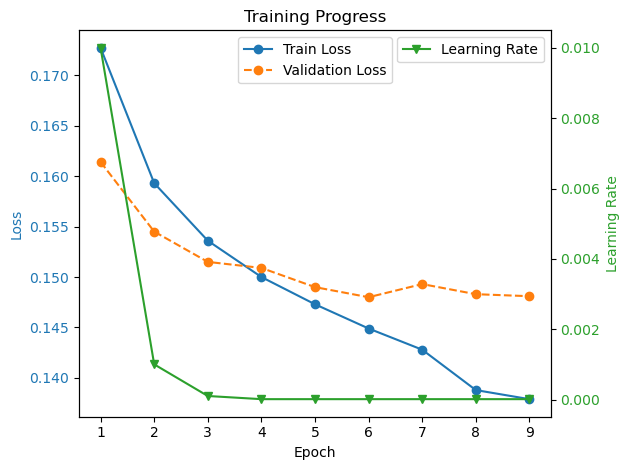

In [3]:
import matplotlib.pyplot as plt

# Data from the training process
epochs = training_data[0]
train_loss = training_data[1]
val_loss = training_data[2]
lr = training_data[3]  # Learning rate at each epoch


# Creating the plots
fig, ax1 = plt.subplots()

# Plotting the loss values
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(epochs, train_loss, label='Train Loss', marker='o', color='tab:blue')
ax1.plot(epochs, val_loss, label='Validation Loss', marker='o', linestyle='--', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper center')

# Creating a second y-axis for learning rate changes
ax2 = ax1.twinx()  
ax2.set_ylabel('Learning Rate', color='tab:green')  
ax2.plot(epochs, lr, label='Learning Rate', marker='v', linestyle='-', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

# Title and show
plt.title('Training Progress')
fig.tight_layout()  
plt.show()


### Accuracy Precision Recall F1-Score

In [4]:
# Re-importing necessary libraries and reloading the data for completeness and troubleshooting

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Load the predictions and actual labels
preds_data = pd.read_csv('D:/School/Major-Project--DEREK/Major-Project-CXR/pretrained-EfficientNet_B3/preds.csv') 
labels_data = pd.read_csv('D:/School/Major-Project--DEREK/Major-Project-CXR/nih_labels.csv')

# Merge predictions and actual labels
merged_data = preds_data.merge(labels_data, on='Image Index', how='inner')

# Define conditions and prepare data
condition_columns = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 
    'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 
    'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 
    'Pleural_Thickening', 'Hernia'
]

pred_columns = [f'prob_{cond}' for cond in condition_columns]

actual_df = merged_data[condition_columns]
pred_df = merged_data[pred_columns]

binary_pred_df = (pred_df >= 0.5).astype(int)

# Calculate performance metrics
performance_metrics = {}
for condition in condition_columns:
    actual = actual_df[condition]
    pred = binary_pred_df[f'prob_{condition}']
    performance_metrics[condition] = {
        'Accuracy': accuracy_score(actual, pred),
        'Precision': precision_score(actual, pred, zero_division=0),
        'Recall': recall_score(actual, pred),
        'F1-Score': f1_score(actual, pred)
    }

performance_metrics_df = pd.DataFrame(performance_metrics).T
performance_metrics_df


,Accuracy,Precision,Recall,F1-Score
Atelectasis,0.890518,0.480836,0.170863,0.252132
Cardiomegaly,0.972630,0.446667,0.230241,0.303855
Effusion,0.891811,0.579738,0.433962,0.496369
Infiltration,0.823251,0.483871,0.079868,0.137106
Mass,0.948736,0.480000,0.115891,0.186704
Nodule,0.940489,0.506098,0.062079,0.110593
Pneumonia,0.988410,0.000000,0.000000,0.000000
Pneumothorax,0.951322,0.493562,0.105601,0.173979
Consolidation,0.957340,0.000000,0.000000,0.000000
Edema,0.981367,0.352941,0.014528,0.027907


In [5]:
# Calculate Hamming Loss
incorrect_labels = np.sum(binary_pred_df.values != actual_df.values)
total_labels = np.prod(actual_df.shape)

hamming_loss_value = incorrect_labels / total_labels

print(f"Hamming Loss: {hamming_loss_value}")


Hamming Loss: 0.05185918703950176


In [6]:
# Continue from the previous code snippet

# Initialize dictionaries to store TP, FP, TN, FN counts
tp_fp_tn_fn_counts = {}

# Calculate TP, FP, TN, FN for each condition
for condition in condition_columns:
    actual = actual_df[condition]
    pred = binary_pred_df[f'prob_{condition}']
    
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(actual, pred).ravel()
    
    # Store the counts
    tp_fp_tn_fn_counts[condition] = [tp, fp, tn, fn]

# Convert to array for easier calculations
tp_fp_tn_fn_array = np.array(list(tp_fp_tn_fn_counts.values()))

# Calculate metrics
TP = tp_fp_tn_fn_array[:, 0]
FP = tp_fp_tn_fn_array[:, 1]
TN = tp_fp_tn_fn_array[:, 2]
FN = tp_fp_tn_fn_array[:, 3]

# Macro-averaged accuracy
macro_accuracy = np.mean((TP + TN) / (TP + FP + TN + FN))

# Correct calculation for class weights for weighted-averaged accuracy
total_instances = TP + FP + TN + FN
class_weights_corrected = total_instances / total_instances.sum()
# Recalculate weighted-averaged accuracy correctly
weighted_accuracy_corrected = np.sum(class_weights_corrected * (TP + TN) / total_instances)


# Micro-averaged accuracy
micro_accuracy = (TP.sum() + TN.sum()) / (TP + FP + TN + FN).sum()

print(f"Macro-averaged Accuracy: {macro_accuracy}")
print(f"Weighted-averaged Accuracy: {weighted_accuracy_corrected}")
print(f"Micro-averaged Accuracy: {micro_accuracy}")


Macro-averaged Accuracy: 0.9481408129604981
Weighted-averaged Accuracy: 0.9481408129604982
Micro-averaged Accuracy: 0.9481408129604982


### ROC and Precision-Recall and CM

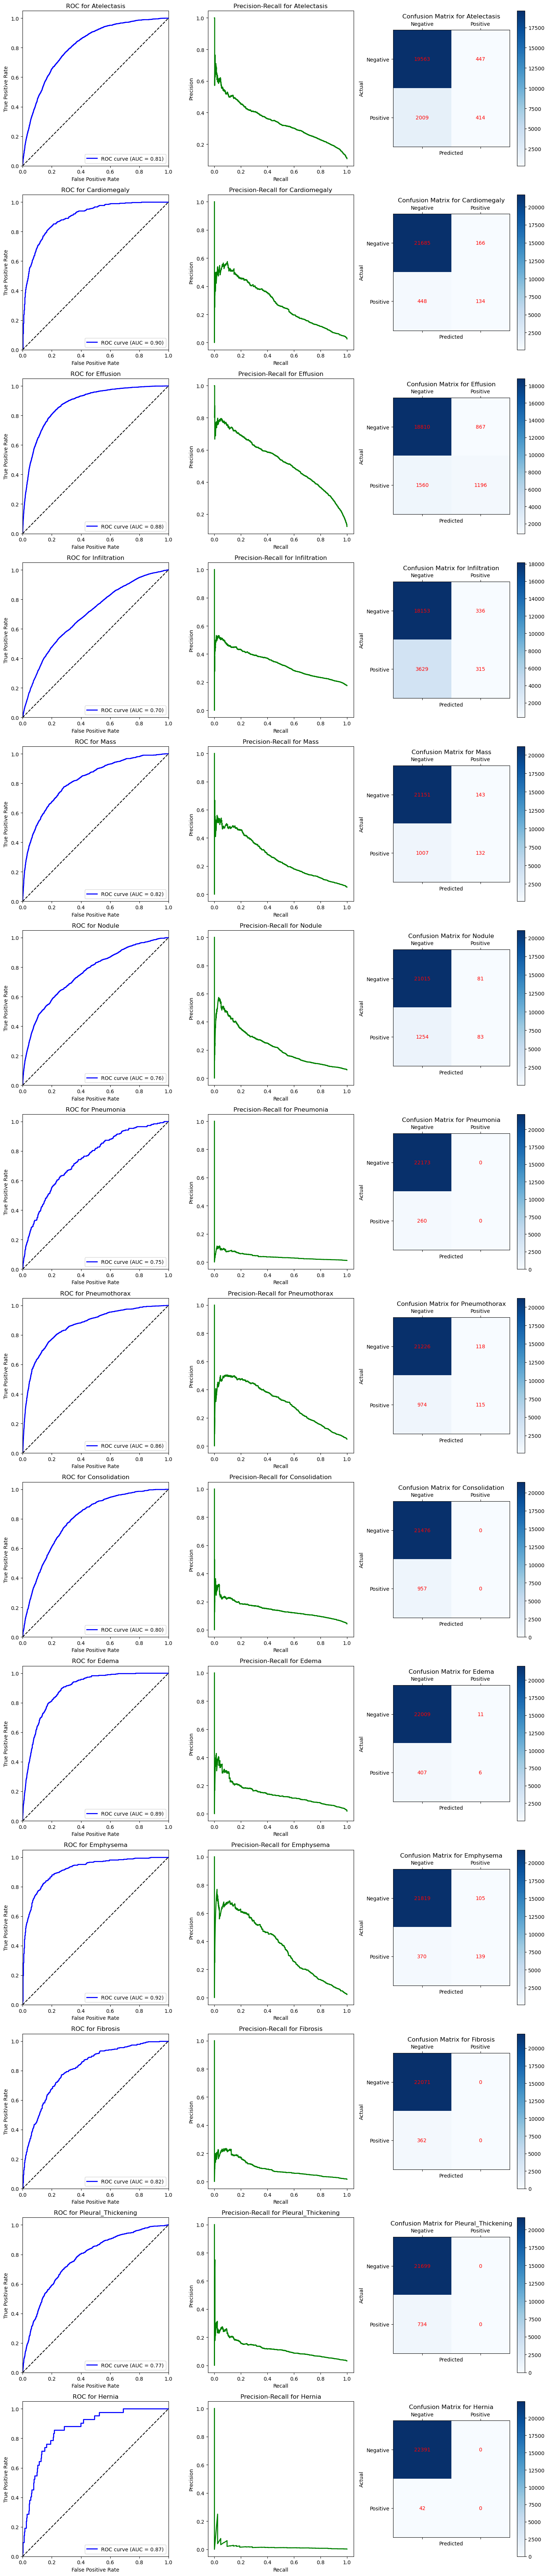

In [7]:
# Generate metrics and plots for a subset of conditions
subset_conditions = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 
    'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 
    'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 
    'Pleural_Thickening', 'Hernia'
]

# Function to create plots for the subset
def plot_subset_metrics(actual_df, pred_df, conditions):
    num_conditions = len(conditions)
    fig, axes = plt.subplots(num_conditions, 3, figsize=(15, 5 * num_conditions))

    for i, condition in enumerate(conditions):
        actual = actual_df[condition]
        pred_prob = pred_df[f'prob_{condition}']
        pred_binary = binary_pred_df[f'prob_{condition}']

        # ROC Curve
        fpr, tpr, _ = roc_curve(actual, pred_prob)
        roc_auc = auc(fpr, tpr)
        axes[i, 0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        axes[i, 0].plot([0, 1], [0, 1], 'k--')
        axes[i, 0].set_xlim([0.0, 1.0])
        axes[i, 0].set_ylim([0.0, 1.05])
        axes[i, 0].set_xlabel('False Positive Rate')
        axes[i, 0].set_ylabel('True Positive Rate')
        axes[i, 0].set_title(f'ROC for {condition}')
        axes[i, 0].legend(loc="lower right")

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(actual, pred_prob)
        axes[i, 1].plot(recall, precision, color='green', lw=2)
        axes[i, 1].set_xlabel('Recall')
        axes[i, 1].set_ylabel('Precision')
        axes[i, 1].set_title(f'Precision-Recall for {condition}')

        # Confusion Matrix
        cm = confusion_matrix(actual, pred_binary)
        cax = axes[i, 2].matshow(cm, cmap=plt.cm.Blues)
        fig.colorbar(cax, ax=axes[i, 2])
        axes[i, 2].set_title(f'Confusion Matrix for {condition}')
        axes[i, 2].set_xlabel('Predicted')
        axes[i, 2].set_ylabel('Actual')
        # Before setting labels, set the tick locations explicitly
        axes[i, 2].set_xticks([0, 1])  # Assuming binary classification
        axes[i, 2].set_yticks([0, 1])

        # Now set the tick labels
        axes[i, 2].set_xticklabels(['Negative', 'Positive'])
        axes[i, 2].set_yticklabels(['Negative', 'Positive'])


        # Annotate Confusion Matrix
        for (j, k), val in np.ndenumerate(cm):
            axes[i, 2].text(k, j, f'{val}', ha='center', va='center', color='red')

    plt.tight_layout()
    return fig

# Plot metrics for the subset of conditions
subset_fig = plot_subset_metrics(actual_df, pred_df, subset_conditions)
plt.show()


### ROC Curves for All Conditions

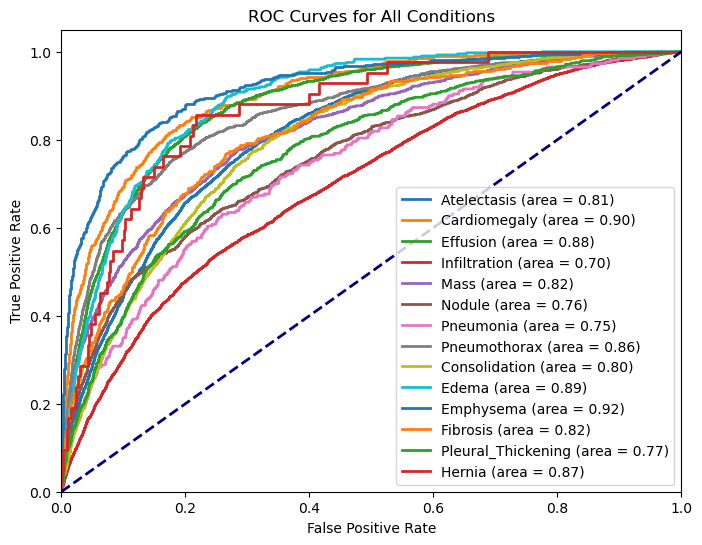

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'actual_df' is your actual labels and 'pred_df' is your predicted probabilities
fig, ax = plt.subplots(figsize=(8, 6))

# Calculate and plot ROC for each condition
for condition in condition_columns:
    actual = actual_df[condition]
    pred_prob = pred_df[f'prob_{condition}']
    fpr, tpr, _ = roc_curve(actual, pred_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, label=f'{condition} (area = {roc_auc:.2f})')

ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves for All Conditions')
ax.legend(loc="lower right")
plt.show()


### Precision-Recall Curves for All Conditions

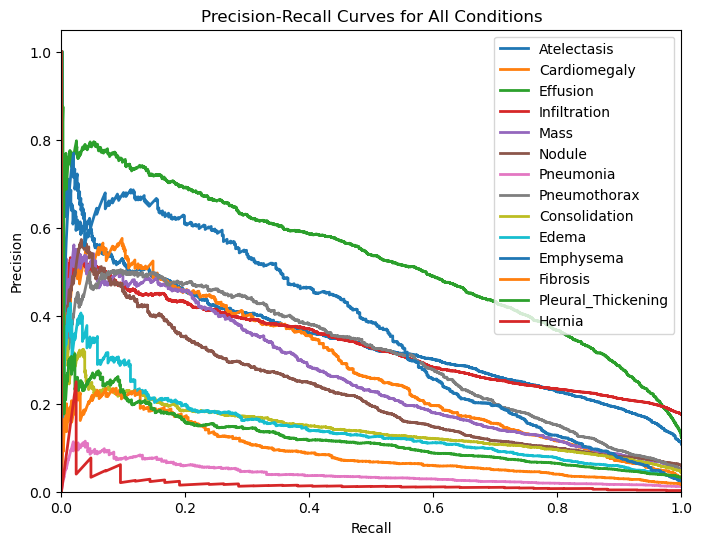

In [9]:
from sklearn.metrics import precision_recall_curve

fig, ax = plt.subplots(figsize=(8, 6))

# Calculate and plot Precision-Recall for each condition
for condition in condition_columns:
    actual = actual_df[condition]
    pred_prob = pred_df[f'prob_{condition}']
    precision, recall, _ = precision_recall_curve(actual, pred_prob)
    ax.plot(recall, precision, lw=2, label=f'{condition}')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim([0.0, 1.05])
ax.set_xlim([0.0, 1.0])
ax.set_title('Precision-Recall Curves for All Conditions')
ax.legend(loc="upper right")
plt.show()


### X